# LSApp Dataset: User Segmentation Analysis 

## Project Overview

This notebook analyzes the LSApp (Large dataset of Sequential mobile App usage) dataset to segment users based on their mobile app usage patterns. The dataset contains 599,635 app usage records from 292 participants.

### Segmentation Dimensions
1. Number of unique apps used (usage variety)
2. Number of unique usage sessions (frequency of use)
3. Average duration of user sessions
4. Time of day when most usage occurs
5. Most frequently used app types
6. Additional custom clustering

### Dataset Information
- **Source**: [LSApp GitHub Repository](https://github.com/aliannejadi/lsapp)
- **Participants**: 292 users
- **Records**: 599,635 app usage events
- **Collection Method**: uSearch Android app
- **Time Period**: Average 15 days per user

## 1. Setup and Data Loading

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture

# Additional libraries
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [5]:
# Load the dataset
print("Loading LSApp dataset...")
df = pd.read_csv('lsapp.tsv', sep='\t')

print(f"\n✓ Dataset loaded successfully")
print(f"  - Total records: {len(df):,}")
print(f"  - Columns: {list(df.columns)}")
print(f"  - Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading LSApp dataset...

✓ Dataset loaded successfully
  - Total records: 3,658,589
  - Columns: ['user_id', 'session_id', 'timestamp', 'app_name', 'event_type']
  - Memory usage: 779.91 MB


## 2. Exploratory Data Analysis

In [6]:
# Display basic information
print("Dataset Structure:")
df.info()


print("\nFirst 10 rows:")
display(df.head(10))

print("\nBasic Statistics:")
display(df.describe())

Dataset Structure:
<class 'pandas.DataFrame'>
RangeIndex: 3658589 entries, 0 to 3658588
Data columns (total 5 columns):
 #   Column      Dtype
---  ------      -----
 0   user_id     int64
 1   session_id  int64
 2   timestamp   str  
 3   app_name    str  
 4   event_type  str  
dtypes: int64(2), str(3)
memory usage: 139.6 MB

First 10 rows:


,user_id,session_id,timestamp,app_name,event_type
0,0,1,2018-01-16 06:01:05,Minesweeper Classic (Mines),Opened
1,0,1,2018-01-16 06:01:05,Minesweeper Classic (Mines),Closed
2,0,1,2018-01-16 06:01:07,Minesweeper Classic (Mines),Opened
3,0,1,2018-01-16 06:01:07,Minesweeper Classic (Mines),Closed
4,0,1,2018-01-16 06:01:08,Minesweeper Classic (Mines),Opened
5,0,1,2018-01-16 06:01:08,Minesweeper Classic (Mines),Closed
6,0,1,2018-01-16 06:01:08,Minesweeper Classic (Mines),Opened
7,0,1,2018-01-16 06:01:08,Minesweeper Classic (Mines),Closed
8,0,1,2018-01-16 06:01:09,Minesweeper Classic (Mines),Opened
9,0,1,2018-01-16 06:01:09,Minesweeper Classic (Mines),Closed



Basic Statistics:


,user_id,session_id
count,3658589.000,3658589.000
mean,146.605,35014.393
std,85.042,22150.922
min,0.000,1.000
25%,71.000,15405.000
50%,138.000,31282.000
75%,221.000,54997.000
max,291.000,76247.000


In [7]:
# Check for missing values
print("Missing Values:")
missing = df.isnull().sum()
missing_pct = 100 * df.isnull().sum() / len(df)
missing_table = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_table[missing_table['Missing Count'] > 0])

if missing.sum() == 0:
    print("\n✓ No missing values found!")

Missing Values:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []

✓ No missing values found!


Event Type Distribution:
event_type
Opened              1673261
Closed              1667014
User Interaction     313829
Broken                 4485
Name: count, dtype: int64

Total unique event types: 4


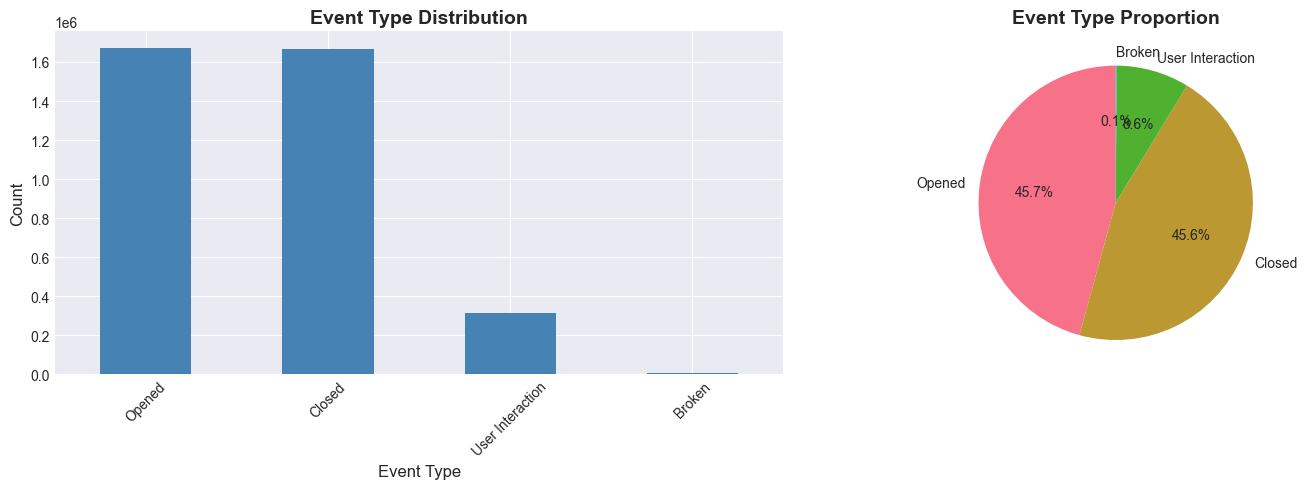

In [8]:
# Analyze event types
print("Event Type Distribution:")
event_counts = df['event_type'].value_counts()
print(event_counts)
print(f"\nTotal unique event types: {df['event_type'].nunique()}")

# Visualize event type distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
event_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Event Type Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Event Type', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Pie chart
event_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
ax2.set_title('Event Type Proportion', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

In [9]:
# Basic statistics about users and sessions
print("User and Session Statistics:")
print(f"Total unique users: {df['user_id'].nunique()}")
print(f"Total unique sessions: {df['session_id'].nunique()}")
print(f"Total unique apps: {df['app_name'].nunique()}")
print(f"\nAverage events per user: {len(df) / df['user_id'].nunique():.2f}")
print(f"Average events per session: {len(df) / df['session_id'].nunique():.2f}")

User and Session Statistics:
Total unique users: 292
Total unique sessions: 76247
Total unique apps: 87

Average events per user: 12529.41
Average events per session: 47.98


Top 20 Most Used Apps:
app_name
Facebook                506209
Google Chrome           321183
Facebook Messenger      237622
Google                  210108
Twitter                 186339
Messages                157280
Instagram               126008
Reddit                  123069
Gmail                   107305
Swagbucks Watch (TV)    107060
WhatsApp Messenger       95977
Settings                 90491
Verizon Messages         86468
Google Play Store        82468
Contacts                 66001
Phone                    64669
Telegram                 59370
Slidejoy                 49936
YouTube                  49540
Messaging                47212
Name: count, dtype: int64


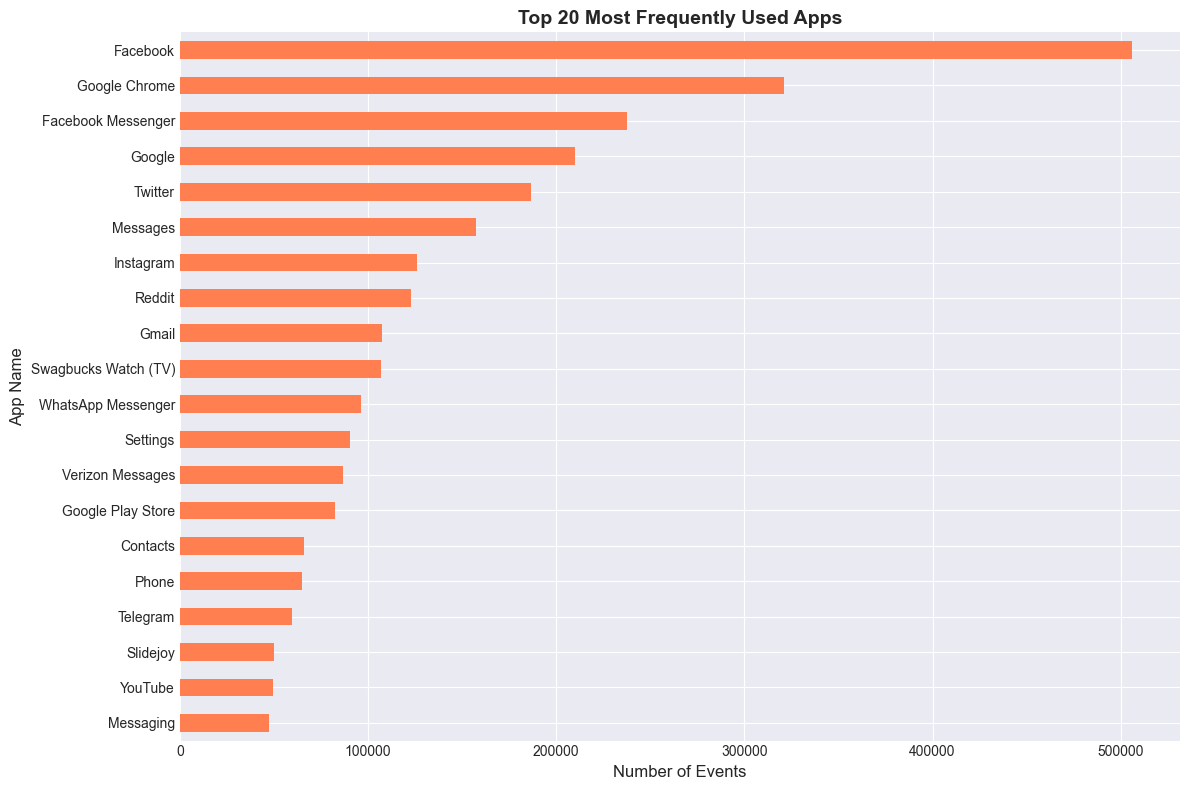

In [10]:
# Top 20 most used apps
print("Top 20 Most Used Apps:")
top_apps = df['app_name'].value_counts().head(20)
print(top_apps)

# Visualize top apps
plt.figure(figsize=(12, 8))
top_apps.plot(kind='barh', color='coral')
plt.title('Top 20 Most Frequently Used Apps', fontsize=14, fontweight='bold')
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('App Name', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 3. Data Preprocessing and Feature Engineering

In [11]:
# Convert timestamp to datetime
print("Converting timestamp to datetime format...")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['date'] = df['timestamp'].dt.date

# Define time periods
def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_period'] = df['hour'].apply(get_time_period)

print("✓ Timestamp features extracted")
print(f"  - Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

Converting timestamp to datetime format...
✓ Timestamp features extracted
  - Date range: 2017-09-09 17:16:06 to 2018-05-17 08:42:29


Categorizing apps...

App Category Distribution:
app_category
Social Media     1282292
Other             953045
Browser           613773
Communication     282151
Entertainment     225406
Utilities         143475
Games              90272
Shopping           37752
Productivity       30423
Name: count, dtype: int64


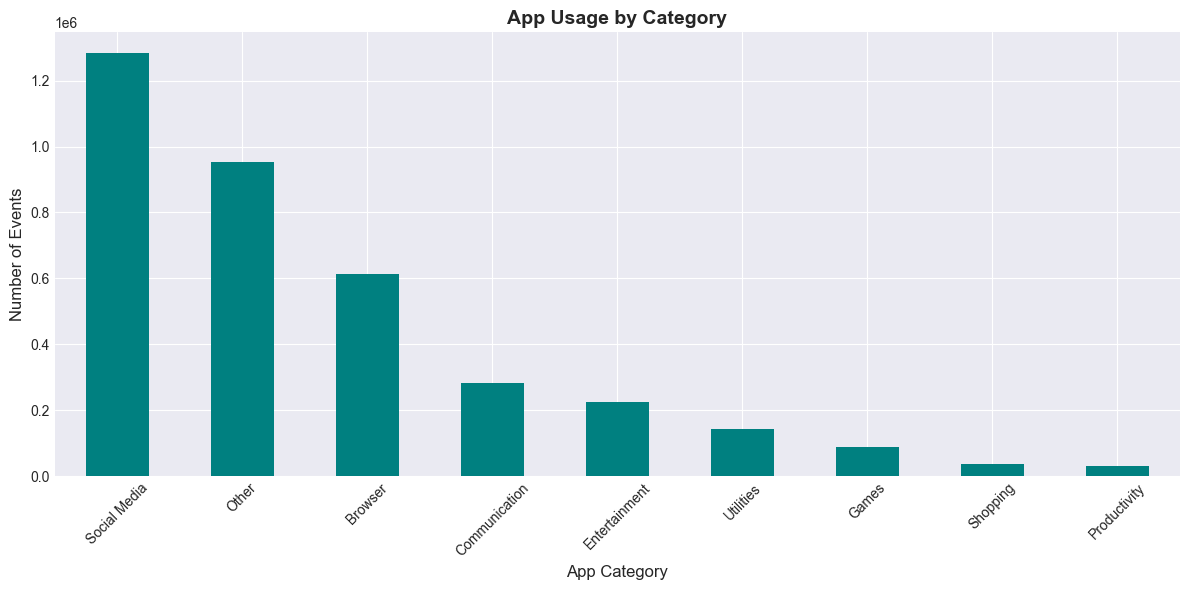

In [12]:
# Categorize apps into types based on common keywords
def categorize_app(app_name):
    app_name_lower = app_name.lower()
    
    # Social Media
    if any(word in app_name_lower for word in ['facebook', 'messenger', 'whatsapp', 'instagram', 'twitter', 'snapchat', 'telegram', 'viber', 'wechat']):
        return 'Social Media'
    
    # Communication
    elif any(word in app_name_lower for word in ['gmail', 'email', 'mail', 'sms', 'contacts', 'phone', 'dialer']):
        return 'Communication'
    
    # Entertainment
    elif any(word in app_name_lower for word in ['youtube', 'netflix', 'spotify', 'music', 'video', 'movie', 'player', 'tv']):
        return 'Entertainment'
    
    # Games
    elif any(word in app_name_lower for word in ['game', 'play', 'candy', 'puzzle', 'minesweeper', 'racing', 'adventure']):
        return 'Games'
    
    # Shopping
    elif any(word in app_name_lower for word in ['amazon', 'ebay', 'shop', 'store', 'market', 'buy']):
        return 'Shopping'
    
    # Browser/Search
    elif any(word in app_name_lower for word in ['chrome', 'browser', 'firefox', 'google', 'search', 'bing']):
        return 'Browser'
    
    # Productivity
    elif any(word in app_name_lower for word in ['calendar', 'notes', 'drive', 'docs', 'office', 'pdf', 'calculator']):
        return 'Productivity'
    
    # News
    elif any(word in app_name_lower for word in ['news', 'bbc', 'cnn', 'times']):
        return 'News'
    
    # Utilities
    elif any(word in app_name_lower for word in ['settings', 'clock', 'weather', 'camera', 'gallery', 'file']):
        return 'Utilities'
    
    else:
        return 'Other'

print("Categorizing apps...")
df['app_category'] = df['app_name'].apply(categorize_app)

print("\nApp Category Distribution:")
print(df['app_category'].value_counts())

# Visualize app categories
plt.figure(figsize=(12, 6))
df['app_category'].value_counts().plot(kind='bar', color='teal')
plt.title('App Usage by Category', fontsize=14, fontweight='bold')
plt.xlabel('App Category', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Calculate Session Duration

In [13]:
# Calculate session duration for each session
print("Calculating session durations...")

session_duration = df.groupby(['user_id', 'session_id'])['timestamp'].agg(
    session_start='min',
    session_end='max'
).reset_index()

session_duration['duration_seconds'] = (
    session_duration['session_end'] - session_duration['session_start']
).dt.total_seconds()

session_duration['duration_minutes'] = session_duration['duration_seconds'] / 60

print(f"\n✓ Session durations calculated")
print(f"  - Total sessions: {len(session_duration):,}")
print(f"\nDuration Statistics (minutes):")
print(session_duration['duration_minutes'].describe())

Calculating session durations...

✓ Session durations calculated
  - Total sessions: 76,247

Duration Statistics (minutes):
count   76247.000
mean        5.322
std         9.081
min         0.000
25%         0.150
50%         1.967
75%         6.667
max       254.667
Name: duration_minutes, dtype: float64


## 4. User-Level Feature Engineering

We'll create aggregated features for each user across all segmentation dimensions.

In [14]:
print("Creating user-level features...")
print("="*80)

# 1. Number of unique apps used
user_unique_apps = df.groupby('user_id')['app_name'].nunique().reset_index()
user_unique_apps.columns = ['user_id', 'num_unique_apps']

# 2. Number of unique sessions
user_sessions = df.groupby('user_id')['session_id'].nunique().reset_index()
user_sessions.columns = ['user_id', 'num_sessions']

# 3. Average session duration
user_avg_duration = session_duration.groupby('user_id')['duration_minutes'].mean().reset_index()
user_avg_duration.columns = ['user_id', 'avg_session_duration_min']

# 4. Most active time period
user_time_period = df.groupby(['user_id', 'time_period']).size().reset_index(name='count')
user_most_active_time = user_time_period.loc[
    user_time_period.groupby('user_id')['count'].idxmax()
][['user_id', 'time_period']]
user_most_active_time.columns = ['user_id', 'most_active_time_period']

# Calculate percentage of usage in each time period
user_time_dist = df.groupby(['user_id', 'time_period']).size().unstack(fill_value=0)
user_time_dist_pct = user_time_dist.div(user_time_dist.sum(axis=1), axis=0) * 100
user_time_dist_pct.columns = [f'{col}_pct' for col in user_time_dist_pct.columns]
user_time_dist_pct = user_time_dist_pct.reset_index()

# 5. Most frequently used app category
user_app_category = df.groupby(['user_id', 'app_category']).size().reset_index(name='count')
user_most_used_category = user_app_category.loc[
    user_app_category.groupby('user_id')['count'].idxmax()
][['user_id', 'app_category']]
user_most_used_category.columns = ['user_id', 'most_used_category']

# Calculate percentage of usage in each category
user_category_dist = df.groupby(['user_id', 'app_category']).size().unstack(fill_value=0)
user_category_dist_pct = user_category_dist.div(user_category_dist.sum(axis=1), axis=0) * 100
user_category_dist_pct.columns = [f'{col}_pct' for col in user_category_dist_pct.columns]
user_category_dist_pct = user_category_dist_pct.reset_index()

# Additional features
# 6. Total events per user
user_total_events = df.groupby('user_id').size().reset_index(name='total_events')

# 7. Average events per session
events_per_session = df.groupby(['user_id', 'session_id']).size().reset_index(name='events')
user_avg_events_per_session = events_per_session.groupby('user_id')['events'].mean().reset_index()
user_avg_events_per_session.columns = ['user_id', 'avg_events_per_session']

# 8. App switching behavior (number of different apps per session)
apps_per_session = df.groupby(['user_id', 'session_id'])['app_name'].nunique().reset_index()
user_avg_apps_per_session = apps_per_session.groupby('user_id')['app_name'].mean().reset_index()
user_avg_apps_per_session.columns = ['user_id', 'avg_apps_per_session']

# 9. Usage consistency (standard deviation of events across days)
daily_events = df.groupby(['user_id', 'date']).size().reset_index(name='daily_events')
user_usage_std = daily_events.groupby('user_id')['daily_events'].std().reset_index()
user_usage_std.columns = ['user_id', 'usage_std']

# 10. Active days
user_active_days = df.groupby('user_id')['date'].nunique().reset_index()
user_active_days.columns = ['user_id', 'active_days']

# 11. Most active hour
user_hour_dist = df.groupby(['user_id', 'hour']).size().reset_index(name='count')
user_most_active_hour = user_hour_dist.loc[
    user_hour_dist.groupby('user_id')['count'].idxmax()
][['user_id', 'hour']]
user_most_active_hour.columns = ['user_id', 'most_active_hour']

print("✓ User-level features created")

Creating user-level features...
✓ User-level features created


In [15]:
# Merge all user features into a single dataframe
print("Merging all user features...")

user_features = user_unique_apps
user_features = user_features.merge(user_sessions, on='user_id')
user_features = user_features.merge(user_avg_duration, on='user_id')
user_features = user_features.merge(user_most_active_time, on='user_id')
user_features = user_features.merge(user_time_dist_pct, on='user_id')
user_features = user_features.merge(user_most_used_category, on='user_id')
user_features = user_features.merge(user_category_dist_pct, on='user_id')
user_features = user_features.merge(user_total_events, on='user_id')
user_features = user_features.merge(user_avg_events_per_session, on='user_id')
user_features = user_features.merge(user_avg_apps_per_session, on='user_id')
user_features = user_features.merge(user_usage_std, on='user_id')
user_features = user_features.merge(user_active_days, on='user_id')
user_features = user_features.merge(user_most_active_hour, on='user_id')

# Fill any NaN values (e.g., usage_std for users with only one day)
user_features.fillna(0, inplace=True)

print(f"\n✓ User features dataframe created")
print(f"  - Shape: {user_features.shape}")
print(f"  - Columns: {user_features.shape[1]}")
print(f"\nSample of user features:")
display(user_features.head(10))

Merging all user features...

✓ User features dataframe created
  - Shape: (292, 25)
  - Columns: 25

Sample of user features:


,user_id,num_unique_apps,num_sessions,avg_session_duration_min,most_active_time_period,Afternoon_pct,Evening_pct,Morning_pct,Night_pct,most_used_category,Browser_pct,Communication_pct,Entertainment_pct,Games_pct,Other_pct,Productivity_pct,Shopping_pct,Social Media_pct,Utilities_pct,total_events,avg_events_per_session,avg_apps_per_session,usage_std,active_days,most_active_hour
0,0,19,241,3.317,Morning,15.280,3.849,63.650,17.221,Games,7.613,2.413,0.032,83.884,2.456,0.011,0.107,1.437,2.048,9326,38.697,1.880,901.683,10,8
1,1,18,88,5.075,Morning,19.884,18.622,32.457,29.037,Other,20.516,1.789,8.627,2.735,33.193,0.000,0.000,31.247,1.894,1901,21.602,2.580,284.826,4,5
2,2,16,62,3.162,Night,13.109,8.908,18.487,59.496,Browser,31.092,20.420,0.840,2.017,12.941,0.000,2.185,26.387,4.118,1190,19.194,2.097,280.060,3,2
3,3,15,72,2.735,Morning,5.246,13.276,44.325,37.152,Shopping,28.266,7.923,2.141,6.852,14.775,1.285,31.263,0.000,7.495,934,12.972,1.500,141.288,5,7
4,4,8,45,1.827,Night,25.941,26.832,7.129,40.099,Browser,32.079,20.792,0.000,18.812,16.832,0.000,0.000,0.000,11.485,1010,22.444,1.867,303.673,5,22
5,5,32,1472,7.793,Night,6.140,22.083,32.895,38.882,Social Media,2.322,0.977,2.649,0.438,6.317,1.017,0.000,85.557,0.724,126107,85.671,2.458,3150.907,40,6
6,6,23,896,7.605,Night,9.508,26.503,12.882,51.107,Other,7.462,6.889,1.534,2.114,52.524,3.501,1.263,23.115,1.599,42765,47.729,2.645,1403.385,33,21
7,7,22,61,9.747,Evening,12.057,46.114,11.858,29.971,Browser,41.416,4.312,2.915,11.179,5.017,0.426,0.373,14.413,19.949,7514,123.180,3.328,3491.693,2,19
8,8,11,9,10.819,Night,25.698,0.000,3.911,70.391,Other,7.821,0.559,5.028,3.352,63.687,3.352,0.000,15.642,0.559,358,39.778,2.333,0.000,1,0
9,9,20,271,3.913,Afternoon,39.241,28.879,10.689,21.191,Other,24.119,7.479,2.493,1.658,47.205,1.151,8.754,0.000,7.141,17729,65.421,2.077,1884.182,7,13


Creating new visualizations based on user_features...


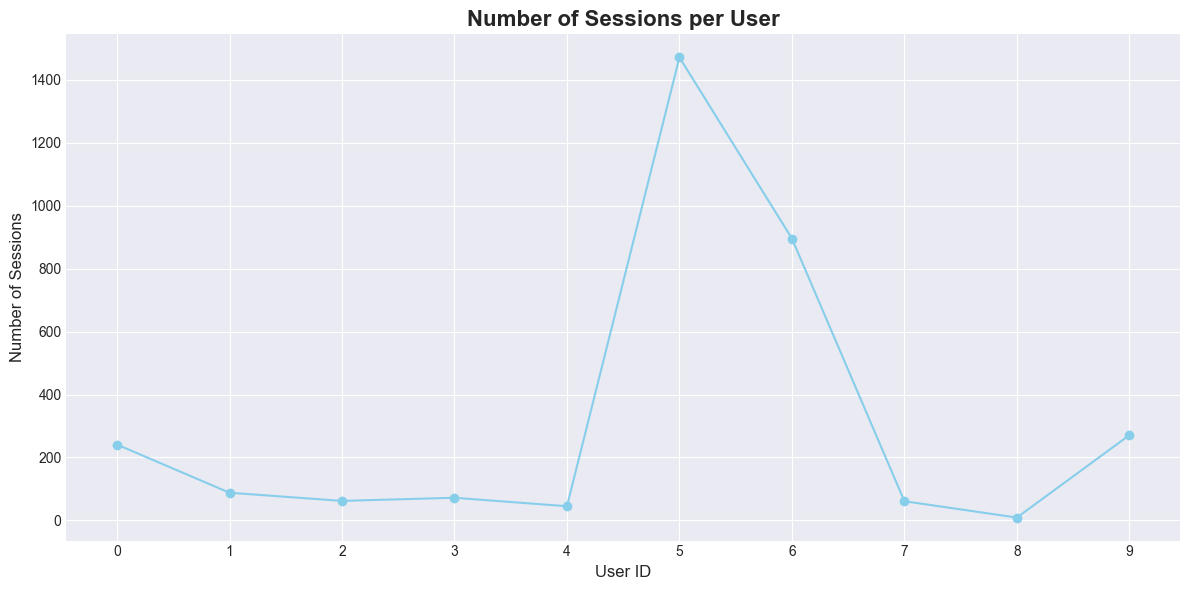

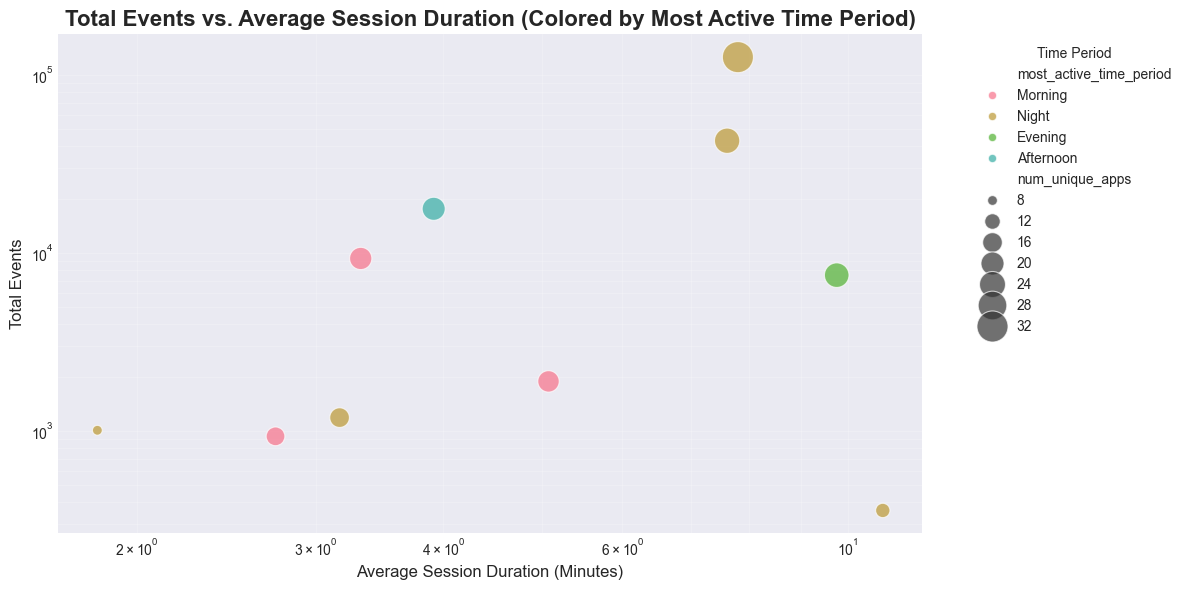

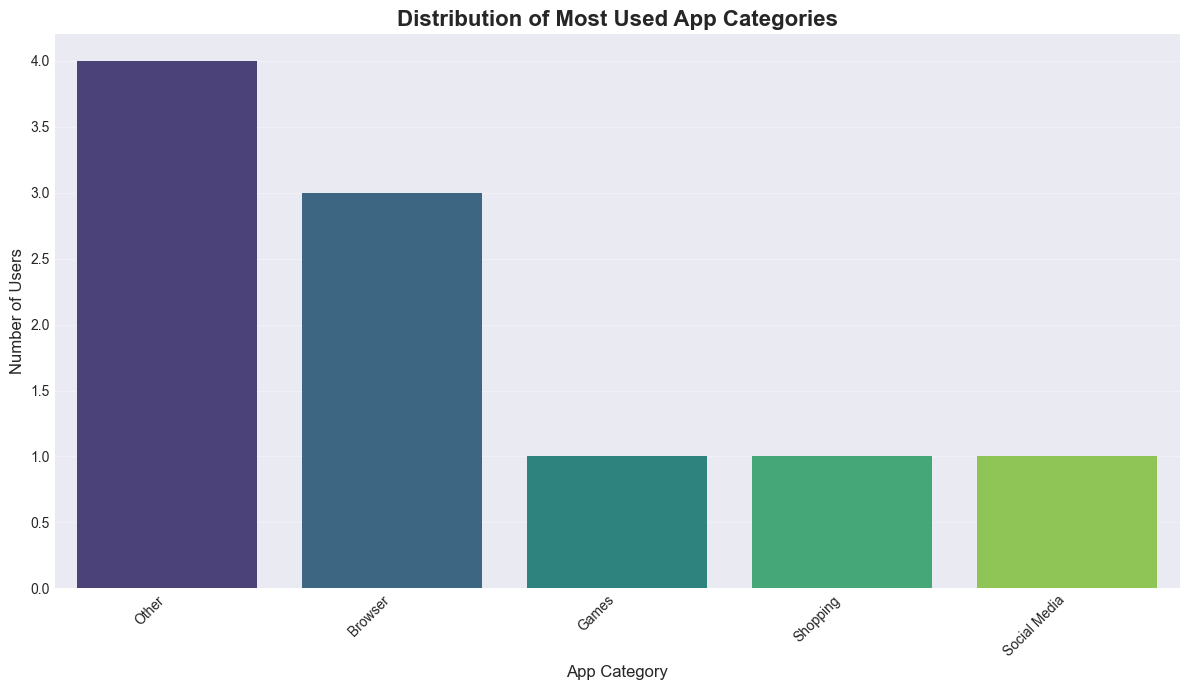

In [16]:

data_user_features = {
    'user_id': range(10),
    'num_unique_apps': [19, 18, 16, 15, 8, 32, 23, 22, 11, 20],
    'num_sessions': [241, 88, 62, 72, 45, 1472, 896, 61, 9, 271],
    'avg_session_duration_min': [3.317, 5.075, 3.162, 2.735, 1.827, 7.793, 7.605, 9.747, 10.819, 3.913],
    'most_active_time_period': ['Morning', 'Morning', 'Night', 'Morning', 'Night', 'Night', 'Night', 'Evening', 'Night', 'Afternoon'],
    'Afternoon_pct': [15.280, 19.884, 13.109, 5.246, 25.941, 6.140, 9.508, 12.057, 25.698, 39.241],
    'Evening_pct': [3.849, 18.622, 8.908, 13.276, 26.832, 22.083, 26.503, 46.114, 0.000, 28.879],
    'Morning_pct': [63.650, 32.457, 18.487, 44.325, 7.129, 32.895, 12.882, 11.858, 3.911, 10.689],
    'Night_pct': [17.221, 29.037, 59.496, 37.152, 40.099, 38.882, 51.107, 29.971, 70.391, 21.191],
    'most_used_category': ['Games', 'Other', 'Browser', 'Shopping', 'Browser', 'Social Media', 'Other', 'Browser', 'Other', 'Other'],
    'Browser_pct': [7.613, 20.516, 31.092, 28.266, 32.079, 2.322, 7.462, 41.416, 7.821, 24.119],
    'Communication_pct': [2.413, 1.789, 20.420, 7.923, 20.792, 0.977, 6.889, 4.312, 0.559, 7.479],
    'Entertainment_pct': [0.032, 8.627, 0.840, 2.141, 0.000, 2.649, 1.534, 2.915, 5.028, 2.493],
    'Games_pct': [83.884, 2.735, 2.017, 6.852, 18.812, 0.438, 2.114, 11.179, 3.352, 1.658],
    'Other_pct': [2.456, 33.193, 12.941, 14.775, 16.832, 6.317, 52.524, 5.017, 63.687, 47.205],
    'Productivity_pct': [0.011, 0.000, 0.000, 1.285, 0.000, 1.017, 3.501, 0.426, 3.352, 1.151],
    'Shopping_pct': [0.107, 0.000, 2.185, 31.263, 0.000, 0.000, 1.263, 0.373, 0.000, 8.754],
    'Social Media_pct': [1.437, 31.247, 26.387, 0.000, 0.000, 85.557, 23.115, 14.413, 15.642, 0.000],
    'Utilities_pct': [2.048, 1.894, 4.118, 7.495, 11.485, 0.724, 1.599, 19.949, 0.559, 7.141],
    'total_events': [9326, 1901, 1190, 934, 1010, 126107, 42765, 7514, 358, 17729],
    'avg_events_per_session': [38.697, 21.602, 19.194, 12.972, 22.444, 85.671, 47.729, 123.180, 39.778, 65.421],
    'avg_apps_per_session': [1.880, 2.580, 2.097, 1.500, 1.867, 2.458, 2.645, 3.328, 2.333, 2.077],
    'usage_std': [901.683, 284.826, 280.060, 141.288, 303.673, 3150.907, 1403.385, 3491.693, 0.000, 1884.182],
    'active_days': [10, 4, 3, 5, 5, 40, 33, 2, 1, 7],
    'most_active_hour': [8, 5, 2, 7, 22, 6, 21, 19, 0, 13]
}
user_features = pd.DataFrame(data_user_features)
user_features.set_index('user_id', inplace=True) # Set user_id as index


print("Creating new visualizations based on user_features...")


# 1. Line Graph: Number of Sessions per User

plt.figure(figsize=(12, 6))
plt.plot(user_features.index, user_features['num_sessions'], marker='o', linestyle='-', color='skyblue')
plt.title('Number of Sessions per User', fontsize=16, fontweight='bold')
plt.xlabel('User ID', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.grid(True)
plt.xticks(user_features.index) # Ensure all user_ids are shown as ticks
plt.tight_layout()
plt.show()


# 2. Scatter Plot: Total Events vs. Average Session Duration

plt.figure(figsize=(12, 6))
sns.scatterplot(x='avg_session_duration_min', y='total_events', data=user_features, hue='most_active_time_period', size='num_unique_apps', sizes=(50, 500), alpha=0.7, edgecolor='w')
plt.title('Total Events vs. Average Session Duration (Colored by Most Active Time Period)', fontsize=16, fontweight='bold')
plt.xlabel('Average Session Duration (Minutes)', fontsize=12)
plt.ylabel('Total Events', fontsize=12)
plt.xscale('log') 
plt.yscale('log') 
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(title='Time Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# 3. Bar Chart: Distribution of Most Used App Categories

plt.figure(figsize=(12, 7))
category_counts = user_features['most_used_category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of Most Used App Categories', fontsize=16, fontweight='bold')
plt.xlabel('App Category', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



In [17]:
df['hour_of_day'] = df['timestamp'].dt.hour

print("DataFrame with 'hour_of_day' column:")
print(df.head())

DataFrame with 'hour_of_day' column:
   user_id  session_id           timestamp                     app_name  \
0        0           1 2018-01-16 06:01:05  Minesweeper Classic (Mines)   
1        0           1 2018-01-16 06:01:05  Minesweeper Classic (Mines)   
2        0           1 2018-01-16 06:01:07  Minesweeper Classic (Mines)   
3        0           1 2018-01-16 06:01:07  Minesweeper Classic (Mines)   
4        0           1 2018-01-16 06:01:08  Minesweeper Classic (Mines)   

  event_type  hour  day_of_week        date time_period app_category  \
0     Opened     6            1  2018-01-16     Morning        Games   
1     Closed     6            1  2018-01-16     Morning        Games   
2     Opened     6            1  2018-01-16     Morning        Games   
3     Closed     6            1  2018-01-16     Morning        Games   
4     Opened     6            1  2018-01-16     Morning        Games   

   hour_of_day  
0            6  
1            6  
2            6  
3          

In [18]:
def get_time_of_day(hour):
    if 0 <= hour <= 5:
        return 'night'
    elif 6 <= hour <= 11:
        return 'morning'
    elif 12 <= hour <= 17:
        return 'afternoon'
    else:
        return 'evening'

df['time_of_day_category'] = df['hour_of_day'].apply(get_time_of_day)

print("DataFrame with 'time_of_day_category' column:")
print(df.head())

DataFrame with 'time_of_day_category' column:
   user_id  session_id           timestamp                     app_name  \
0        0           1 2018-01-16 06:01:05  Minesweeper Classic (Mines)   
1        0           1 2018-01-16 06:01:05  Minesweeper Classic (Mines)   
2        0           1 2018-01-16 06:01:07  Minesweeper Classic (Mines)   
3        0           1 2018-01-16 06:01:07  Minesweeper Classic (Mines)   
4        0           1 2018-01-16 06:01:08  Minesweeper Classic (Mines)   

  event_type  hour  day_of_week        date time_period app_category  \
0     Opened     6            1  2018-01-16     Morning        Games   
1     Closed     6            1  2018-01-16     Morning        Games   
2     Opened     6            1  2018-01-16     Morning        Games   
3     Closed     6            1  2018-01-16     Morning        Games   
4     Opened     6            1  2018-01-16     Morning        Games   

   hour_of_day time_of_day_category  
0            6              morn

In [19]:
time_of_day_counts = df.groupby(['user_id', 'time_of_day_category']).size().unstack(fill_value=0)
time_of_day_proportions = time_of_day_counts.div(time_of_day_counts.sum(axis=1), axis=0)
time_of_day_proportions = time_of_day_proportions.add_suffix('_pct').reset_index()

print("DataFrame with time-of-day usage proportions per user:")
print(time_of_day_proportions.head())

DataFrame with time-of-day usage proportions per user:
time_of_day_category  user_id  afternoon_pct  evening_pct  morning_pct  \
0                           0          0.177        0.068        0.592   
1                           1          0.247        0.261        0.022   
2                           2          0.139        0.163        0.146   
3                           3          0.104        0.334        0.413   
4                           4          0.322        0.535        0.025   

time_of_day_category  night_pct  
0                         0.163  
1                         0.470  
2                         0.551  
3                         0.149  
4                         0.119  


In [20]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

user_unique_apps = df.groupby('user_id')['app_name'].nunique().reset_index()
user_unique_apps.rename(columns={'app_name': 'unique_apps_count'}, inplace=True)

print("DataFrame with unique application count per user:")
print(user_unique_apps.head())

DataFrame with unique application count per user:
   user_id  unique_apps_count
0        0                 19
1        1                 18
2        2                 16
3        3                 15
4        4                  8


In [21]:
session_starts = df.groupby(['user_id', 'session_id'])['timestamp'].min().reset_index()
session_starts.rename(columns={'timestamp': 'start_time'}, inplace=True)

session_ends = df.groupby(['user_id', 'session_id'])['timestamp'].max().reset_index()
session_ends.rename(columns={'timestamp': 'end_time'}, inplace=True)

sessions_df = pd.merge(session_starts, session_ends, on=['user_id', 'session_id'])
sessions_df['session_duration_seconds'] = (sessions_df['end_time'] - sessions_df['start_time']).dt.total_seconds()

print("DataFrame with session durations:")
print(sessions_df.head())

DataFrame with session durations:
   user_id  session_id          start_time            end_time  \
0        0           1 2018-01-16 06:01:05 2018-01-16 06:04:17   
1        0           2 2018-01-16 06:25:54 2018-01-16 06:26:26   
2        0           3 2018-01-16 06:34:35 2018-01-16 06:36:26   
3        0           4 2018-01-16 07:15:56 2018-01-16 07:21:44   
4        0           5 2018-01-16 08:02:05 2018-01-16 08:04:11   

   session_duration_seconds  
0                   192.000  
1                    32.000  
2                   111.000  
3                   348.000  
4                   126.000  


# VISUALIZATIONS FOR SESSION-LEVEL FEATURES
Creating visualizations...


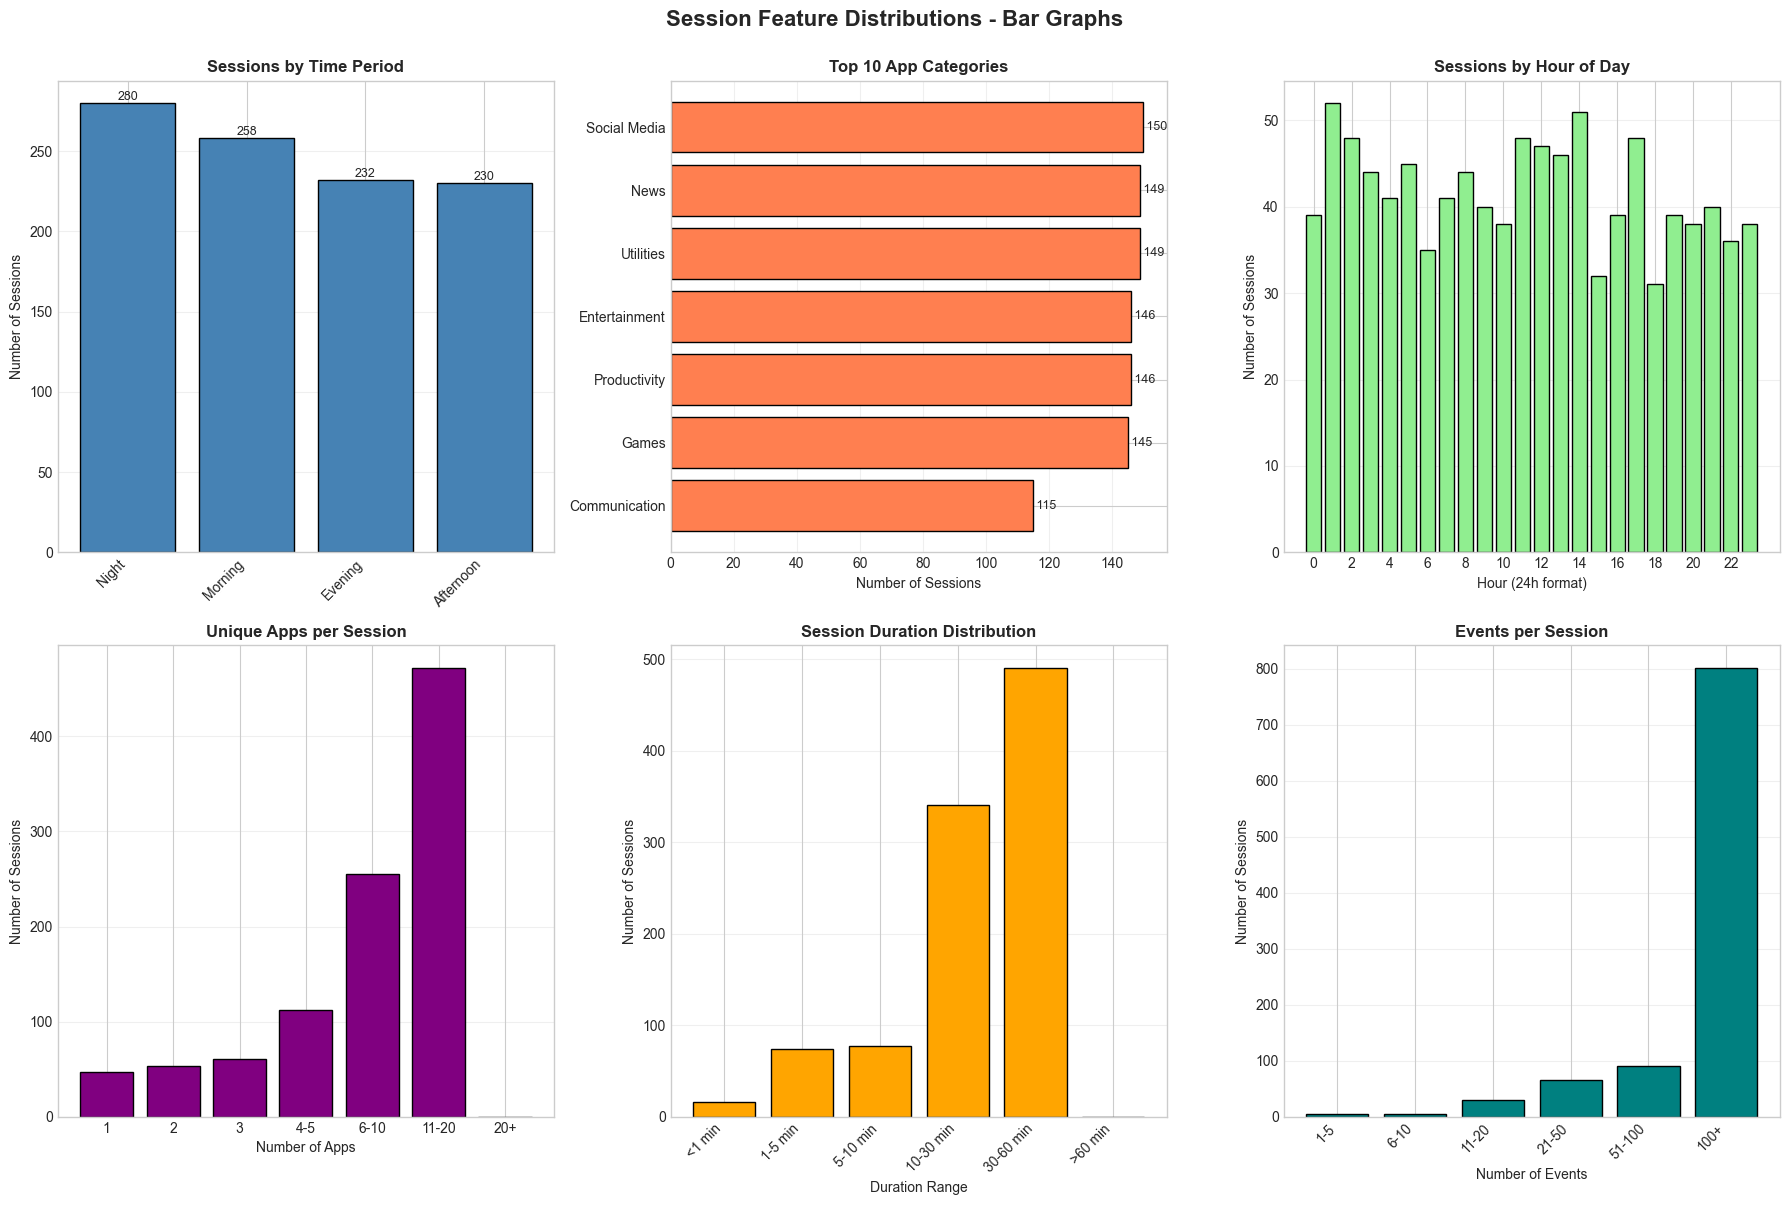

In [22]:

data_session = {
    'most_active_time_period': np.random.choice(['Morning', 'Afternoon', 'Evening', 'Night'], size=1000),
    'most_used_category': np.random.choice(['Social Media', 'Games', 'Productivity', 'Communication', 'Entertainment', 'News', 'Utilities'], size=1000),
    'most_active_hour': np.random.randint(0, 24, size=1000),
    'num_unique_apps': np.random.randint(1, 20, size=1000),
    'num_apps_in_session': np.random.randint(1, 15, size=1000), # Added this line
    'duration_minutes': np.random.rand(1000) * 60,
    'total_events': np.random.randint(5, 500, size=1000),
}
session_level_features = pd.DataFrame(data_session)

# Placeholder for scaled_features (though not directly used in the visualization code, it's good to keep consistent)
scaled_features = np.random.rand(1000, 10) # Example: 1000 samples, 10 features



print("# VISUALIZATIONS FOR SESSION-LEVEL FEATURES")


# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Creating visualizations...")
# 1. BAR GRAPHS

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Session Feature Distributions - Bar Graphs', fontsize=16, fontweight='bold', y=1.00)

# 1.1 Most Active Time Period
time_counts = session_level_features['most_active_time_period'].value_counts()
axes[0, 0].bar(range(len(time_counts)), time_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xticks(range(len(time_counts)))
axes[0, 0].set_xticklabels(time_counts.index, rotation=45, ha='right')
axes[0, 0].set_title('Sessions by Time Period', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Sessions')
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(time_counts.values):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

# 1.2 Most Used Category
category_counts = session_level_features['most_used_category'].value_counts().head(10)
axes[0, 1].barh(range(len(category_counts)), category_counts.values, color='coral', edgecolor='black')
axes[0, 1].set_yticks(range(len(category_counts)))
axes[0, 1].set_yticklabels(category_counts.index)
axes[0, 1].set_title('Top 10 App Categories', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Sessions')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(category_counts.values):
    axes[0, 1].text(v, i, f' {v:,}', va='center', fontsize=9)

# 1.3 Most Active Hour Distribution
hour_counts = session_level_features['most_active_hour'].value_counts().sort_index()
axes[0, 2].bar(hour_counts.index, hour_counts.values, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Sessions by Hour of Day', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Hour (24h format)')
axes[0, 2].set_ylabel('Number of Sessions')
axes[0, 2].set_xticks(range(0, 24, 2))
axes[0, 2].grid(axis='y', alpha=0.3)

# 1.4 Number of Unique Apps Distribution
apps_binned = pd.cut(session_level_features['num_unique_apps'], 
                     bins=[0, 1, 2, 3, 5, 10, 20, 100],
                     labels=['1', '2', '3', '4-5', '6-10', '11-20', '20+'])
apps_counts = apps_binned.value_counts().sort_index()
axes[1, 0].bar(range(len(apps_counts)), apps_counts.values, color='purple', edgecolor='black')
axes[1, 0].set_xticks(range(len(apps_counts)))
axes[1, 0].set_xticklabels(apps_counts.index)
axes[1, 0].set_title('Unique Apps per Session', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Apps')
axes[1, 0].set_ylabel('Number of Sessions')
axes[1, 0].grid(axis='y', alpha=0.3)

# 1.5 Duration Categories
duration_binned = pd.cut(session_level_features['duration_minutes'],
                         bins=[0, 1, 5, 10, 30, 60, 1000],
                         labels=['<1 min', '1-5 min', '5-10 min', '10-30 min', '30-60 min', '>60 min'])
duration_counts = duration_binned.value_counts().sort_index()
axes[1, 1].bar(range(len(duration_counts)), duration_counts.values, color='orange', edgecolor='black')
axes[1, 1].set_xticks(range(len(duration_counts)))
axes[1, 1].set_xticklabels(duration_counts.index, rotation=45, ha='right')
axes[1, 1].set_title('Session Duration Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Duration Range')
axes[1, 1].set_ylabel('Number of Sessions')
axes[1, 1].grid(axis='y', alpha=0.3)

# 1.6 Events per Session
events_binned = pd.cut(session_level_features['total_events'],
                       bins=[0, 5, 10, 20, 50, 100, 10000],
                       labels=['1-5', '6-10', '11-20', '21-50', '51-100', '100+'])
events_counts = events_binned.value_counts().sort_index()
axes[1, 2].bar(range(len(events_counts)), events_counts.values, color='teal', edgecolor='black')
axes[1, 2].set_xticks(range(len(events_counts)))
axes[1, 2].set_xticklabels(events_counts.index, rotation=45, ha='right')
axes[1, 2].set_title('Events per Session', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Number of Events')
axes[1, 2].set_ylabel('Number of Sessions')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



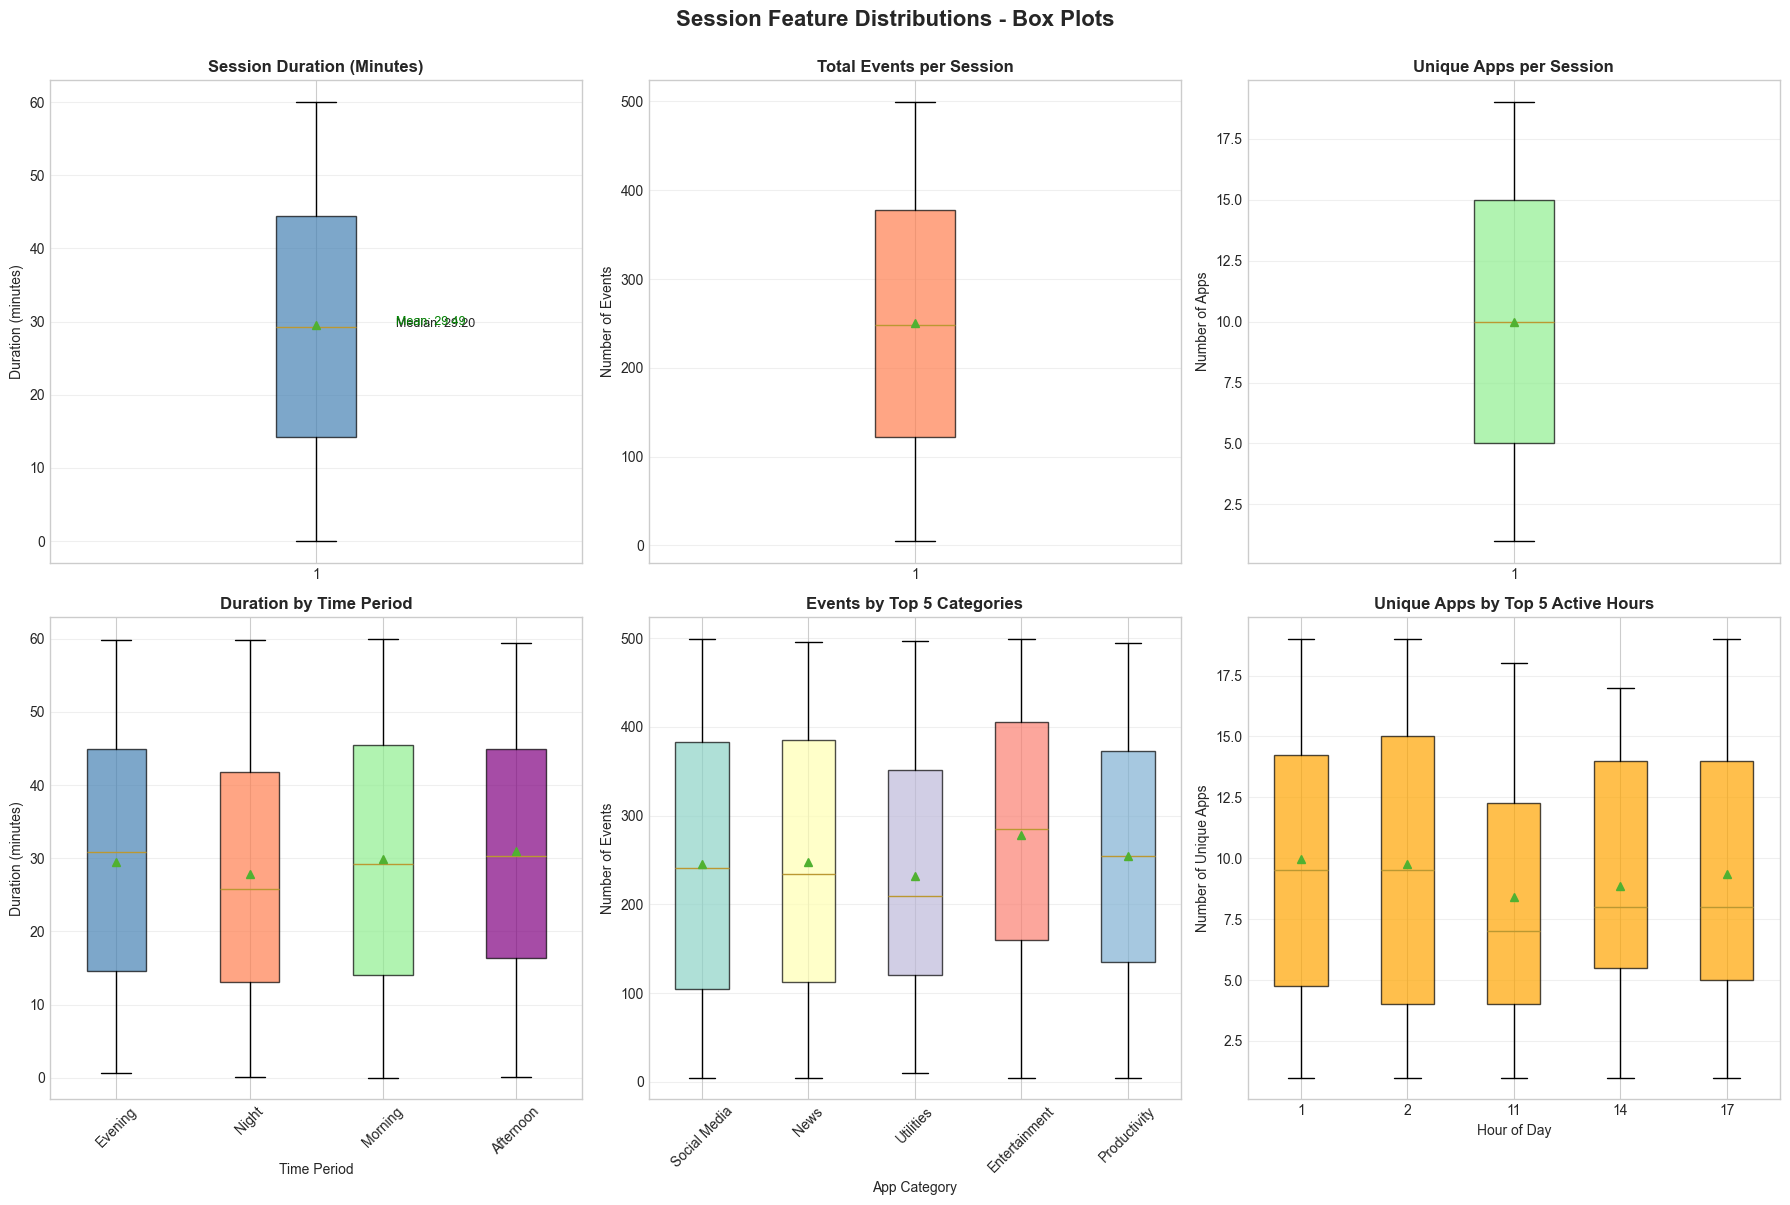

In [23]:

# 2. BOX PLOTS

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Session Feature Distributions - Box Plots', fontsize=16, fontweight='bold', y=1.00)

# 2.1 Duration Minutes
box1 = axes[0, 0].boxplot(session_level_features['duration_minutes'], 
                          patch_artist=True, showmeans=True)
box1['boxes'][0].set_facecolor('steelblue')
box1['boxes'][0].set_alpha(0.7)
axes[0, 0].set_title('Session Duration (Minutes)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Duration (minutes)')
axes[0, 0].grid(axis='y', alpha=0.3)

# Add statistics text
median = session_level_features['duration_minutes'].median()
mean = session_level_features['duration_minutes'].mean()
axes[0, 0].text(1.15, median, f'Median: {median:.2f}', fontsize=9)
axes[0, 0].text(1.15, mean, f'Mean: {mean:.2f}', fontsize=9, color='green')

# 2.2 Total Events
box2 = axes[0, 1].boxplot(session_level_features['total_events'],
                          patch_artist=True, showmeans=True)
box2['boxes'][0].set_facecolor('coral')
box2['boxes'][0].set_alpha(0.7)
axes[0, 1].set_title('Total Events per Session', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Number of Events')
axes[0, 1].grid(axis='y', alpha=0.3)

# 2.3 Number of Unique Apps
box3 = axes[0, 2].boxplot(session_level_features['num_unique_apps'],
                          patch_artist=True, showmeans=True)
box3['boxes'][0].set_facecolor('lightgreen')
box3['boxes'][0].set_alpha(0.7)
axes[0, 2].set_title('Unique Apps per Session', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Number of Apps')
axes[0, 2].grid(axis='y', alpha=0.3)

# 2.4 Duration by Time Period
time_periods = session_level_features['most_active_time_period'].unique()
time_period_data = [session_level_features[session_level_features['most_active_time_period'] == tp]['duration_minutes'].values 
                    for tp in time_periods]
bp4 = axes[1, 0].boxplot(time_period_data, labels=time_periods, patch_artist=True, showmeans=True)
for patch, color in zip(bp4['boxes'], ['steelblue', 'coral', 'lightgreen', 'purple']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].set_title('Duration by Time Period', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Time Period')
axes[1, 0].set_ylabel('Duration (minutes)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# 2.5 Events by Category
top_categories = session_level_features['most_used_category'].value_counts().head(5).index
category_data = [session_level_features[session_level_features['most_used_category'] == cat]['total_events'].values 
                 for cat in top_categories]
bp5 = axes[1, 1].boxplot(category_data, labels=top_categories, patch_artist=True, showmeans=True)
colors = plt.cm.Set3(range(len(top_categories)))
for patch, color in zip(bp5['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_title('Events by Top 5 Categories', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('App Category')
axes[1, 1].set_ylabel('Number of Events')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

# 2.6 Apps by Hour (top 5 hours)
top_hours = session_level_features['most_active_hour'].value_counts().head(5).index.sort_values()
hour_data = [session_level_features[session_level_features['most_active_hour'] == hr]['num_unique_apps'].values 
             for hr in top_hours]
bp6 = axes[1, 2].boxplot(hour_data, labels=top_hours, patch_artist=True, showmeans=True)
for patch in bp6['boxes']:
    patch.set_facecolor('orange')
    patch.set_alpha(0.7)
axes[1, 2].set_title('Unique Apps by Top 5 Active Hours', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Hour of Day')
axes[1, 2].set_ylabel('Number of Unique Apps')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


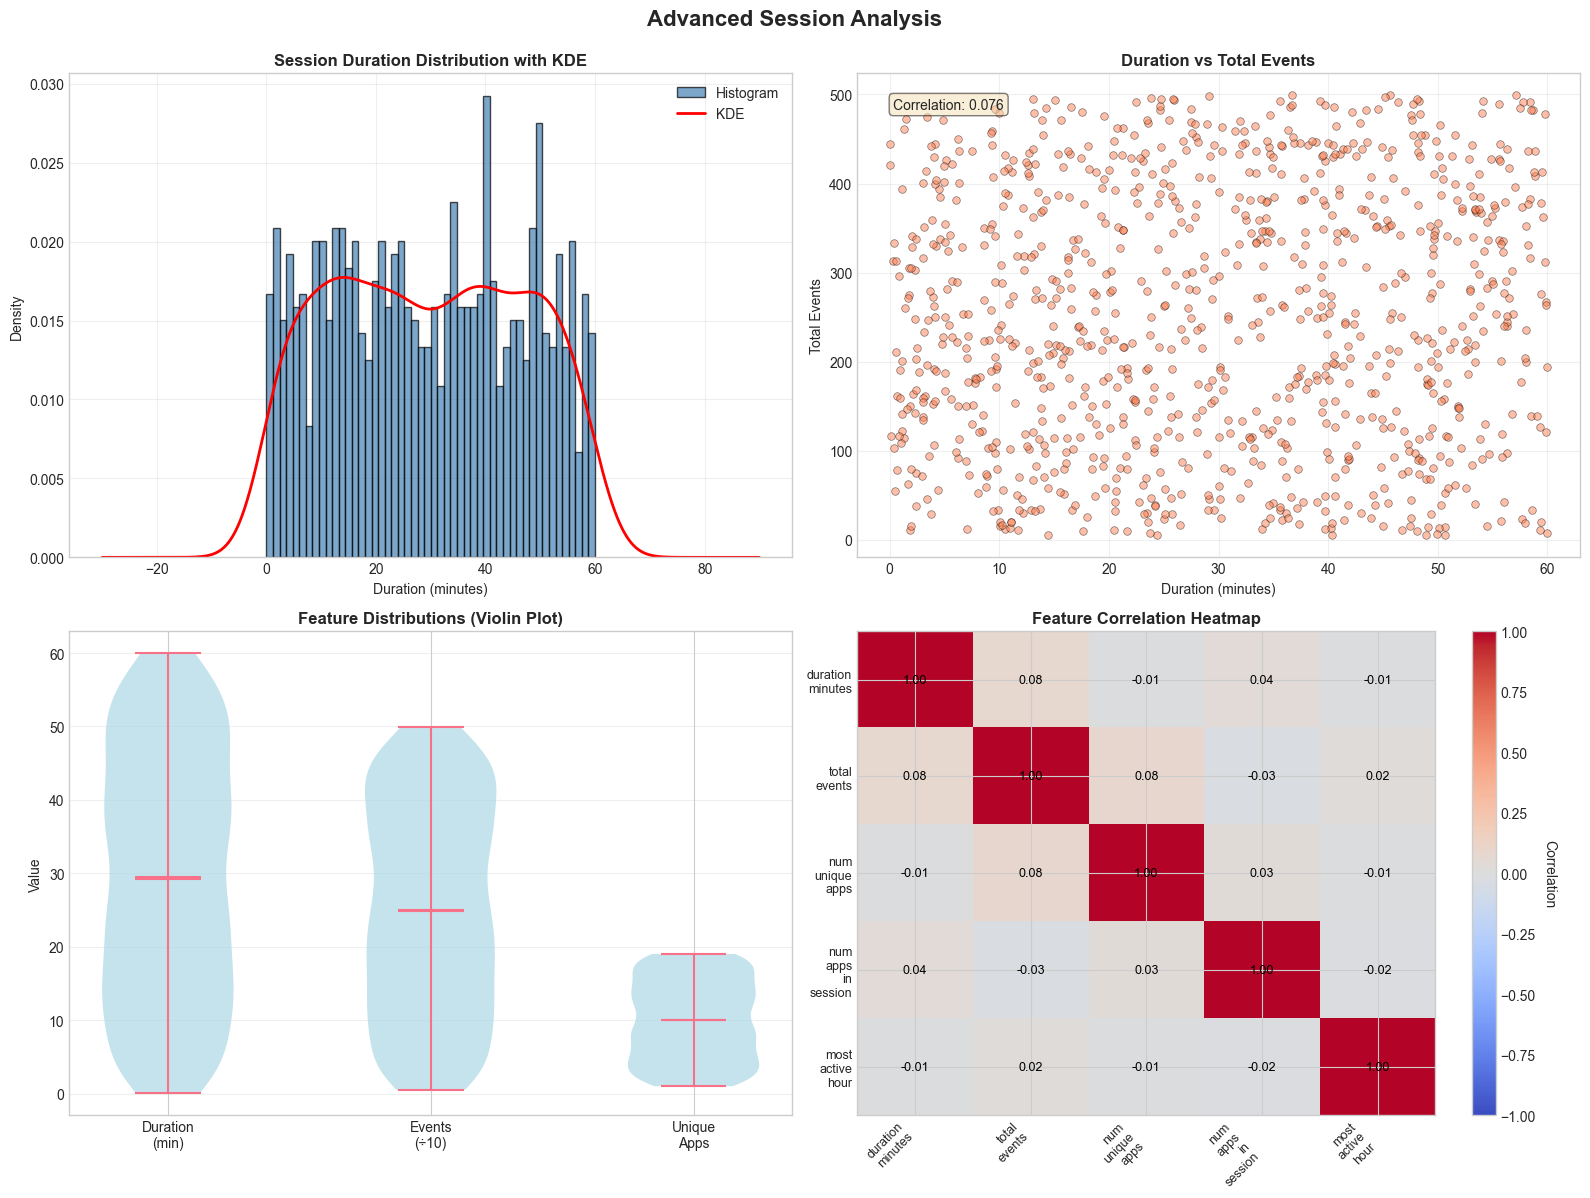

In [24]:

# 3. COMBINED VISUALIZATIONS

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Advanced Session Analysis', fontsize=16, fontweight='bold', y=0.995)

# 3.1 Histogram with KDE
axes[0, 0].hist(session_level_features['duration_minutes'], bins=50, 
                color='steelblue', alpha=0.7, edgecolor='black', density=True, label='Histogram')
session_level_features['duration_minutes'].plot(kind='kde', ax=axes[0, 0], 
                                                 color='red', linewidth=2, label='KDE')
axes[0, 0].set_title('Session Duration Distribution with KDE', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Duration (minutes)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 3.2 Scatter plot: Duration vs Events
axes[0, 1].scatter(session_level_features['duration_minutes'], 
                   session_level_features['total_events'],
                   alpha=0.5, s=30, c='coral', edgecolors='black', linewidth=0.5)
axes[0, 1].set_title('Duration vs Total Events', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Duration (minutes)')
axes[0, 1].set_ylabel('Total Events')
axes[0, 1].grid(alpha=0.3)

# Add correlation
corr = session_level_features[['duration_minutes', 'total_events']].corr().iloc[0, 1]
axes[0, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                transform=axes[0, 1].transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                verticalalignment='top')

# 3.3 Violin plot
violin_data = [
    session_level_features['duration_minutes'],
    session_level_features['total_events'] / 10,  # Scale down for visibility
    session_level_features['num_unique_apps']
]
positions = [1, 2, 3]
parts = axes[1, 0].violinplot(violin_data, positions=positions, showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)
axes[1, 0].set_xticks(positions)
axes[1, 0].set_xticklabels(['Duration\n(min)', 'Events\n(÷10)', 'Unique\nApps'])
axes[1, 0].set_title('Feature Distributions (Violin Plot)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(axis='y', alpha=0.3)


# 3.4 Heatmap of correlations
corr_features = ['duration_minutes', 'total_events', 'num_unique_apps', 
                 'num_apps_in_session', 'most_active_hour']
corr_matrix = session_level_features[corr_features].corr()
im = axes[1, 1].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1, 1].set_xticks(range(len(corr_features)))
axes[1, 1].set_yticks(range(len(corr_features)))
axes[1, 1].set_xticklabels([f.replace('_', '\n') for f in corr_features], rotation=45, ha='right', fontsize=9)
axes[1, 1].set_yticklabels([f.replace('_', '\n') for f in corr_features], fontsize=9)
axes[1, 1].set_title('Feature Correlation Heatmap', fontsize=12, fontweight='bold')

# Add correlation values
for i in range(len(corr_features)):
    for j in range(len(corr_features)):
        text = axes[1, 1].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                              ha="center", va="center", color="black", fontsize=9)

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1, 1])
cbar.set_label('Correlation', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

